Comparison of `mle_regression = False / True` for state space model with intervention variable regression


- [Jacques J. F. Commandeur and Siem Jan Koopman, An Introduction to State Space Time Series Analysis (Practical Econometrics) ](https://www.amazon.co.jp/dp/0199228876/ref=cm_sw_r_tw_dp_897A7MBN34NXEFDWYPHF?_encoding=UTF8&psc=1)
    - Data: http://www.ssfpack.com/CKbook.html
    - Japanese Translation: [状態空間時系列分析入門   J.J.F. コマンダー ](https://www.amazon.co.jp/dp/4916092929/ref=cm_sw_r_tw_dp_ENXRFY89QBMRWFVPDVMG )

When we use dummy variables for regression in state space model,  
diffuse initialization period (`nobs_diffuse`) can be different depending on whether `mle_regression = False/True`.

See also discussion in [GitHub Issue](https://github.com/statsmodels/statsmodels/issues/7342)

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

## UK data

- UK drivers KSI (killed or seriously injured)
- UK petrol price
- seat belt law (since Feb. 1983, dummy variable)

In [2]:
# KSI
df_ukdrivers = pd.read_csv('../data/ckbook/UKdriversKSI.txt', skiprows=[0], header=None)
df_ukdrivers.columns = ['drivers']
df_ukdrivers['log_drivers'] = np.log(df_ukdrivers['drivers'])
df_ukdrivers.index = pd.date_range(start='1969-01', periods=df_ukdrivers.shape[0], freq='M')

In [3]:
# Petrol price
df_ukpetrol = pd.read_csv('../data/ckbook/logUKpetrolprice.txt')
df_ukpetrol.columns = ['log_petrol_price']
df_ukpetrol.index = pd.date_range(start='1969-01', periods=df_ukpetrol.shape[0], freq='M')

In [4]:
# Seat belt law
dummy_var_seatbelt = pd.Series(df_ukdrivers.index >= datetime.datetime(1983, 2,1), index=df_ukdrivers.index).astype(int)

In [5]:
df_uk_all = df_ukdrivers[['log_drivers']].copy()
df_uk_all['log_petrol_price'] = df_ukpetrol['log_petrol_price']
df_uk_all['seatbelt'] = dummy_var_seatbelt
df_uk_all.head()

,log_drivers,log_petrol_price,seatbelt
1969-01-31,7.430707,-2.27330,0
1969-02-28,7.318540,-2.27923,0
1969-03-31,7.317876,-2.28217,0
1969-04-30,7.233455,-2.29389,0
1969-05-31,7.397562,-2.29244,0


In [6]:
(df_uk_all['seatbelt'] == 0).sum()

169

## Stochastic Level and Stochastic Seasonality

$$
\begin{aligned}
\end{aligned}
\begin{aligned}
y_t &= \mu_t + \gamma_t + \beta_1 x_t + \lambda_1 w_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\mu_{t+1} &= \mu_t + \xi_t, \quad \xi_t \sim N(0, \sigma_\xi^2)\\
\gamma_{t+1} &= -\sum_{k=0}^{s-2}\gamma_{t-k} + \omega_t, \quad \omega_t \sim N(0, \sigma_\omega^2)\\
\end{aligned}
$$

where

$$
\begin{aligned}
\end{aligned}
\begin{aligned}
w_t = 
\begin{cases}
0 \quad t < t_0\\
1 \quad t \ge t_0
\end{cases}
\end{aligned}
$$

### mle_regression=True

Regression coefficients are determined by MLE.

In [7]:
llevel_seasonal_model = sm.tsa.UnobservedComponents(df_uk_all['log_drivers'], 
                                                level='local level', 
                                                seasonal=12, stochastic_seasonal=True,
                                                exog=df_uk_all[['log_petrol_price', 'seatbelt']],
                                                mle_regression=True,
                                                use_exact_diffuse=True)

In [8]:
llevel_seasonal_results = llevel_seasonal_model.fit()

In [9]:
llevel_seasonal_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                   log_drivers   No. Observations:                  192
Model:                           local level   Log Likelihood                 189.660
                   + stochastic seasonal(12)   AIC                           -345.320
Date:                       Tue, 23 Feb 2021   BIC                           -289.943
Time:                               18:12:52   HQIC                          -322.892
Sample:                           01-31-1969                                         
                                - 12-31-1984                                         
Covariance Type:                         opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular          0.0041      0.001      7.452      0.000       0.003       0.005
sigma2.level              0.0002      0.000      2.196      0.028    2.41e-05       0.000
sigma2.seasonal        2.506e-11   3.59e-05   6.99e-07      1.000   -7.03e-05    7.03e-05
beta.log_petrol_price    -0.2816      0.098     -2.879      0.004      -0.473      -0.090
beta.seatbelt            -0.2359      0.045     -5.236      0.000      -0.324      -0.148
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.12   Prob(JB):                         0.27
Heteroskedasticity (H):               0.91   Skew:                            -0.25
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
beta_petrol_llevel_seasonal = llevel_seasonal_results.params['beta.log_petrol_price']
beta_seatbelt_llevel_seasonal = llevel_seasonal_results.params['beta.seatbelt']

print(f'beta1_petrol: {beta_petrol_llevel_seasonal}')
print(f'beta1_seatbelt: {beta_seatbelt_llevel_seasonal}')

beta1_petrol: -0.2816155014317698
beta1_seatbelt: -0.23594573246906894


In [11]:
llevel_seasonal_smoothed = (llevel_seasonal_results.level['smoothed']
                             + beta_petrol_llevel_seasonal * df_uk_all['log_petrol_price'] 
                             + beta_seatbelt_llevel_seasonal * df_uk_all['seatbelt']
                            )

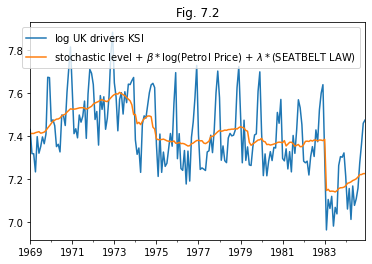

In [12]:
ax = df_uk_all['log_drivers'].plot(label='$\log$ UK drivers KSI')
ax = llevel_seasonal_smoothed.plot(ax=ax, 
                                    label='stochastic level + $\\beta *\\log$(Petrol Price) + $\\lambda *$(SEATBELT LAW)')
ax.set_title('Fig. 7.2')
ax.legend()

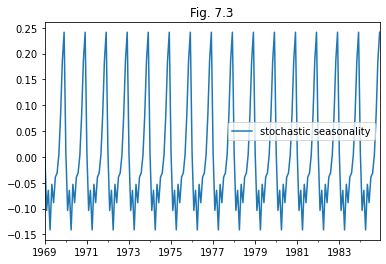

In [13]:
ax = pd.Series(llevel_seasonal_results.seasonal['smoothed'], index=df_ukdrivers.index).plot(label='stochastic seasonality')
ax.set_title('Fig. 7.3')
ax.legend()

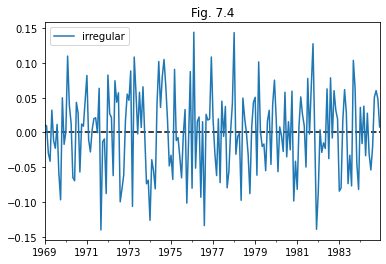

In [14]:
ax = pd.Series(llevel_seasonal_results.smoothed_measurement_disturbance[0], index=df_ukdrivers.index).plot(label='irregular')
ax.hlines(0, *ax.get_xlim(), linestyle='dashed', color='black')
ax.set_title('Fig. 7.4')
ax.legend()

In [15]:
# AIC
llevel_seasonal_results.aic / llevel_seasonal_results.nobs

-1.798542947292874

In [16]:
llevel_seasonal_results.smoother_results.model.design.shape

(1, 12, 1)

In [17]:
# design matrix is time-independent and does not contain regression variables
llevel_seasonal_results.smoother_results.model.design

array([[[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

In [18]:
# 12 for diffuse initialization parameters (level: 1, seasonality: 11)
# 5 for parameters estimated in MLE (noise variances: 3, regression coefficients: 2)
llevel_seasonal_results.df_model

17

In [19]:
# in this case, it coincides with the number of diffuse initialization parameters
llevel_seasonal_results.nobs_diffuse

12

### mle_regression=False

Regression coefficients are determined through diffuse initialization.

In [20]:
mle_false_model = sm.tsa.UnobservedComponents(df_uk_all['log_drivers'], 
                                                level='local level', 
                                                seasonal=12, stochastic_seasonal=True,
                                                exog=df_uk_all[['log_petrol_price', 'seatbelt']],
                                                mle_regression=False,
                                                use_exact_diffuse=True)

In [21]:
mle_false_results = mle_false_model.fit()

In [22]:
mle_false_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                   log_drivers   No. Observations:                  192
Model:                           local level   Log Likelihood                 184.228
                   + stochastic seasonal(12)   AIC                           -334.455
Date:                       Tue, 23 Feb 2021   BIC                           -279.078
Time:                               18:12:54   HQIC                          -312.027
Sample:                           01-31-1969                                         
                                - 12-31-1984                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0040      0.001      7.093      0.000       0.003       0.005
sigma2.level         0.0003      0.000      2.167      0.030    2.56e-05       0.001
sigma2.seasonal   4.173e-12   3.42e-05   1.22e-07      1.000   -6.69e-05    6.69e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.51   Prob(JB):                         0.71
Heteroskedasticity (H):               0.44   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
beta_petrol_mle_false = mle_false_results.regression_coefficients['smoothed'][0, 0]
beta_seatbelt_mle_false = mle_false_results.regression_coefficients['smoothed'][1, 0]

print(f'beta1_petrol: {beta_petrol_mle_false}')
print(f'beta1_seatbelt: {beta_seatbelt_mle_false}')

beta1_petrol: -0.2767375893190713
beta1_seatbelt: -0.23758807390645942


In [24]:
mle_false_smoothed = (mle_false_results.level['smoothed']
                             + beta_petrol_mle_false * df_uk_all['log_petrol_price'] 
                             + beta_seatbelt_mle_false * df_uk_all['seatbelt']
                            )

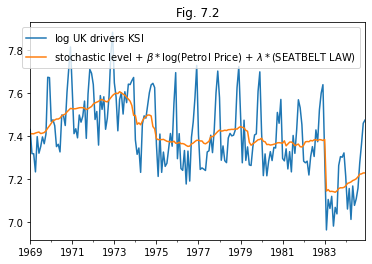

In [25]:
ax = df_uk_all['log_drivers'].plot(label='$\log$ UK drivers KSI')
ax = mle_false_smoothed.plot(ax=ax, 
                                    label='stochastic level + $\\beta *\\log$(Petrol Price) + $\\lambda *$(SEATBELT LAW)')
ax.set_title('Fig. 7.2')
ax.legend()

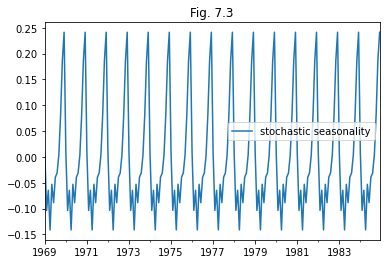

In [26]:
ax = pd.Series(mle_false_results.seasonal['smoothed'], index=df_ukdrivers.index).plot(label='stochastic seasonality')
ax.set_title('Fig. 7.3')
ax.legend()

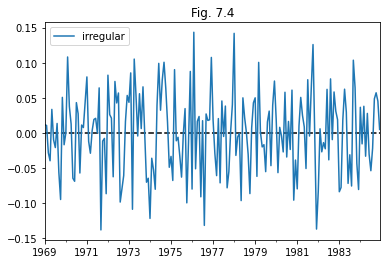

In [27]:
ax = pd.Series(mle_false_results.smoothed_measurement_disturbance[0], index=df_ukdrivers.index).plot(label='irregular')
ax.hlines(0, *ax.get_xlim(), linestyle='dashed', color='black')
ax.set_title('Fig. 7.4')
ax.legend()

In [28]:
# AIC
mle_false_results.aic / mle_false_results.nobs

-1.7419556483418859

In [29]:
mle_false_results.smoother_results.model.design.shape

(1, 14, 192)

In [30]:
# regression variables are in design matrix
mle_false_results.smoother_results.model.design[:, -2:, :]

array([[[-2.2733 , -2.27923, -2.28217, -2.29389, -2.29244, -2.29679,
         -2.26554, -2.26263, -2.26554, -2.27277, -2.27565, -2.28281,
         -2.28992, -2.29557, -2.30119, -2.31647, -2.31923, -2.32197,
         -2.33017, -2.32882, -2.32867, -2.33945, -2.34613, -2.35276,
         -2.33577, -2.34227, -2.35002, -2.35694, -2.36321, -2.36945,
         -2.37565, -2.37688, -2.37812, -2.38304, -2.38916, -2.39402,
         -2.40007, -2.40488, -2.40848, -2.418  , -2.42273, -2.42861,
         -2.42022, -2.42836, -2.41979, -2.43353, -2.43693, -2.44144,
         -2.44819, -2.45489, -2.46043, -2.47906, -2.46993, -2.47531,
         -2.47958, -2.48278, -2.49125, -2.5111 , -2.49068, -2.36244,
         -2.38163, -2.22413, -2.23295, -2.17118, -2.18521, -2.19538,
         -2.20454, -2.2238 , -2.23467, -2.2543 , -2.12563, -2.14028,
         -2.0172 , -2.03374, -2.05324, -2.09113, -2.13211, -2.15126,
         -2.16142, -2.16717, -2.17575, -2.18988, -2.20174, -2.16044,
         -2.17337, -2.18614, -2.19

In [31]:
# 14 for diffuse initialization parameters (level: 1, seasonality: 11, regression coefficients: 2)
# 3 for variances of observation/system noises
mle_false_results.df_model

17

In [32]:
# nobs_diffuse is much larger than `mle_regression = True` case
# because first 169 of the dummy variale are 0 and are not
# informative to parameter estimation.
mle_false_results.nobs_diffuse

170